# Missing Data Demo

### load dependencies

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

### standardize plots

In [3]:
plt.style.use('grayscale')
plt.rc("figure", figsize=(16, 5))

### reader function

In [4]:
def read_dataset(folder, file, date_col=None, format=None, index=False):
    '''
    Reads a CSV dataset from a specified folder and converts date columns to datetime.
    
    Parameters:
    folder: the directory containing the file passed a Path object
    file: the CSV filename in that Path object. 
    date_col: specify a column which has datetime
    format: the date format string for parsing dates
    index: True if date_col should be the index
    
    Returns: 
    pandas DataFrame with a DatetimeIndex
    '''
    index_col = date_col if index is True else None
    
    df = pd.read_csv(folder / file, 
                     index_col=index_col, 
                     parse_dates=[date_col],
                     date_format=format)
    return df

### plotter function

In [5]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''Creates comparative plots of original vs. missing data.
	    hint: df1 is the original dataset, while df2 contains your DataFrame
	    with different imputation strategies
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    
    fig, ax = plt.subplots(subplots_size + 1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    
    if title:
        fig.suptitle(title)
    
    df1[col].plot(ax=ax[0], figsize=(12, 10))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i + 1])
        ax[i + 1].set_title(colname)
    
    fig.tight_layout()
    plt.show()


### rmse score function

In [6]:
def rmse_score(df1, df2, col=None):
    '''Calculates RMSE scores between original and processed data.'''
    if col is None:
        raise ValueError("Column name must be specified")
        
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    
    if len(columns) <= 1:
        raise ValueError("No comparison columns found")
    
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    
    return scores

### read data

In [9]:
folder = Path('')
co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)



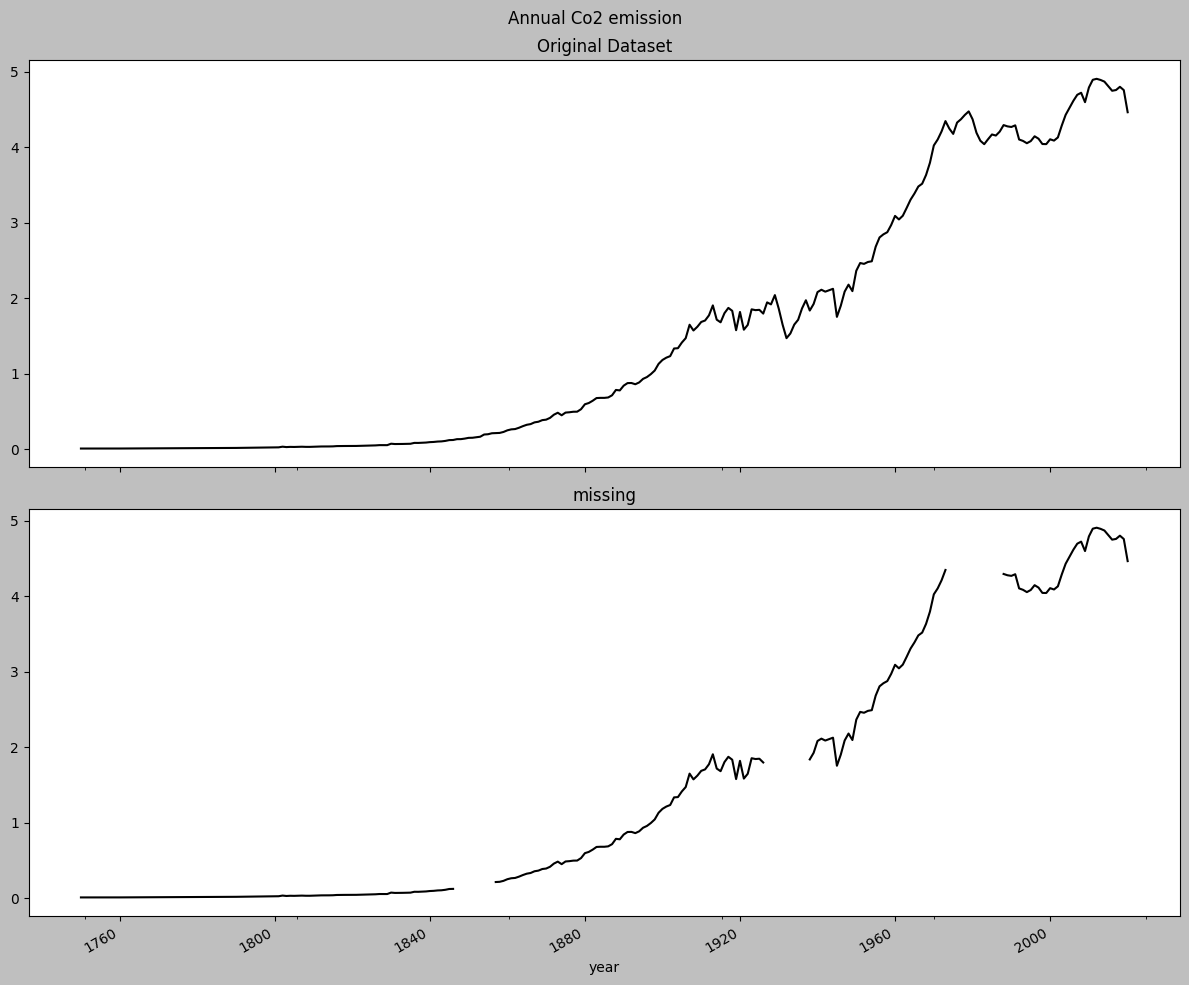

In [10]:
plot_dfs(
    co2_original,
    co2_missing,
    'co2',
    title='Annual Co2 emission'
)

In [11]:
co2_missing.isna().sum()

co2    35
dtype: int64

In [13]:
co2_missing.head()

,co2
year,
1750-01-01,0.0125
1760-01-01,0.0128
1770-01-01,0.0150
1780-01-01,0.0169
1790-01-01,0.0206


### ffill, bfill, fillna

In [15]:
average = co2_missing['co2'].mean()
median = co2_missing['co2'].median()

co2_missing['ffill'] = co2_missing['co2'].ffill()
co2_missing['bfill'] = co2_missing['co2'].bfill()
co2_missing['mean'] = co2_missing['co2'].fillna(average)
co2_missing['0'] = co2_missing['co2'].fillna(0)
co2_missing['median'] = co2_missing['co2'].fillna(median)

In [19]:
co2_missing.head()

,co2,ffill,bfill,mean,0,median
year,,,,,,
1750-01-01,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206,0.0206,0.0206,0.0206


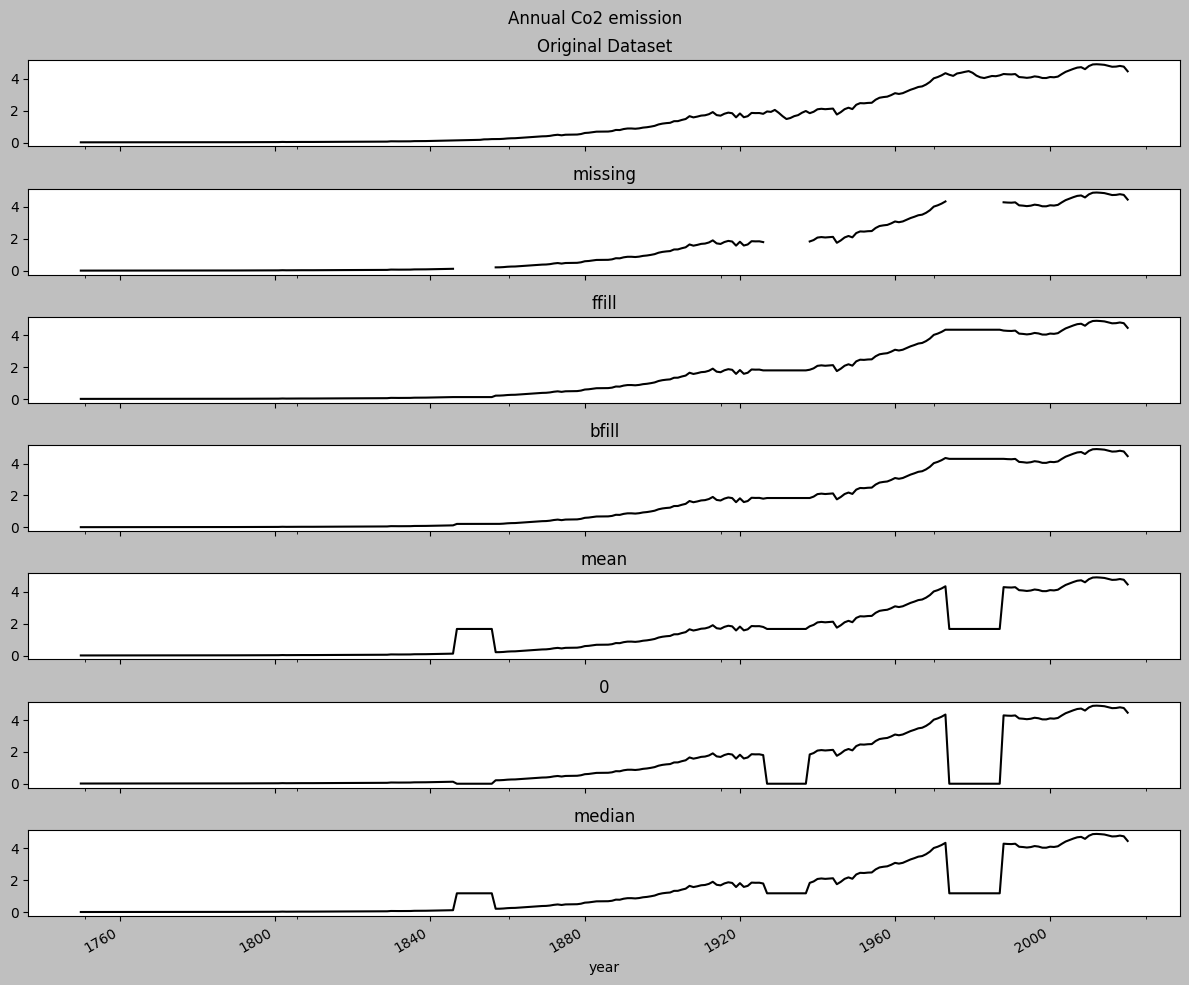

In [20]:
plot_dfs(
    co2_original,
    co2_missing,
    'co2',
    title='Annual Co2 emission'
)

In [22]:
score = rmse_score(co2_original,
                   co2_missing,
                   'co2')

RMSE for ffill: 0.05873012599267133
RMSE for bfill: 0.05550012995280968
RMSE for mean: 0.7156383637041684
RMSE for 0: 1.1285178854727376
RMSE for median: 0.802942160685986


### SimpleImputer

In [23]:
from sklearn.impute import SimpleImputer

In [24]:
folder = Path('')
co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)

In [25]:
mean_imputer = SimpleImputer(strategy='mean')

In [28]:
co2_vals = co2_missing['co2'].values.reshape(-1, 1) #sklearn doesn't work with dfs
co2_missing['mean'] = mean_imputer.fit_transform(co2_vals)
co2_missing.head()

,co2,mean
year,,
1750-01-01,0.0125,0.0125
1760-01-01,0.0128,0.0128
1770-01-01,0.0150,0.0150
1780-01-01,0.0169,0.0169
1790-01-01,0.0206,0.0206


In [30]:
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
co2_missing['most_frequent'] = most_frequent_imputer.fit_transform(co2_vals)
co2_missing.head()

,co2,mean,most_frequent
year,,,
1750-01-01,0.0125,0.0125,0.0125
1760-01-01,0.0128,0.0128,0.0128
1770-01-01,0.0150,0.0150,0.0150
1780-01-01,0.0169,0.0169,0.0169
1790-01-01,0.0206,0.0206,0.0206


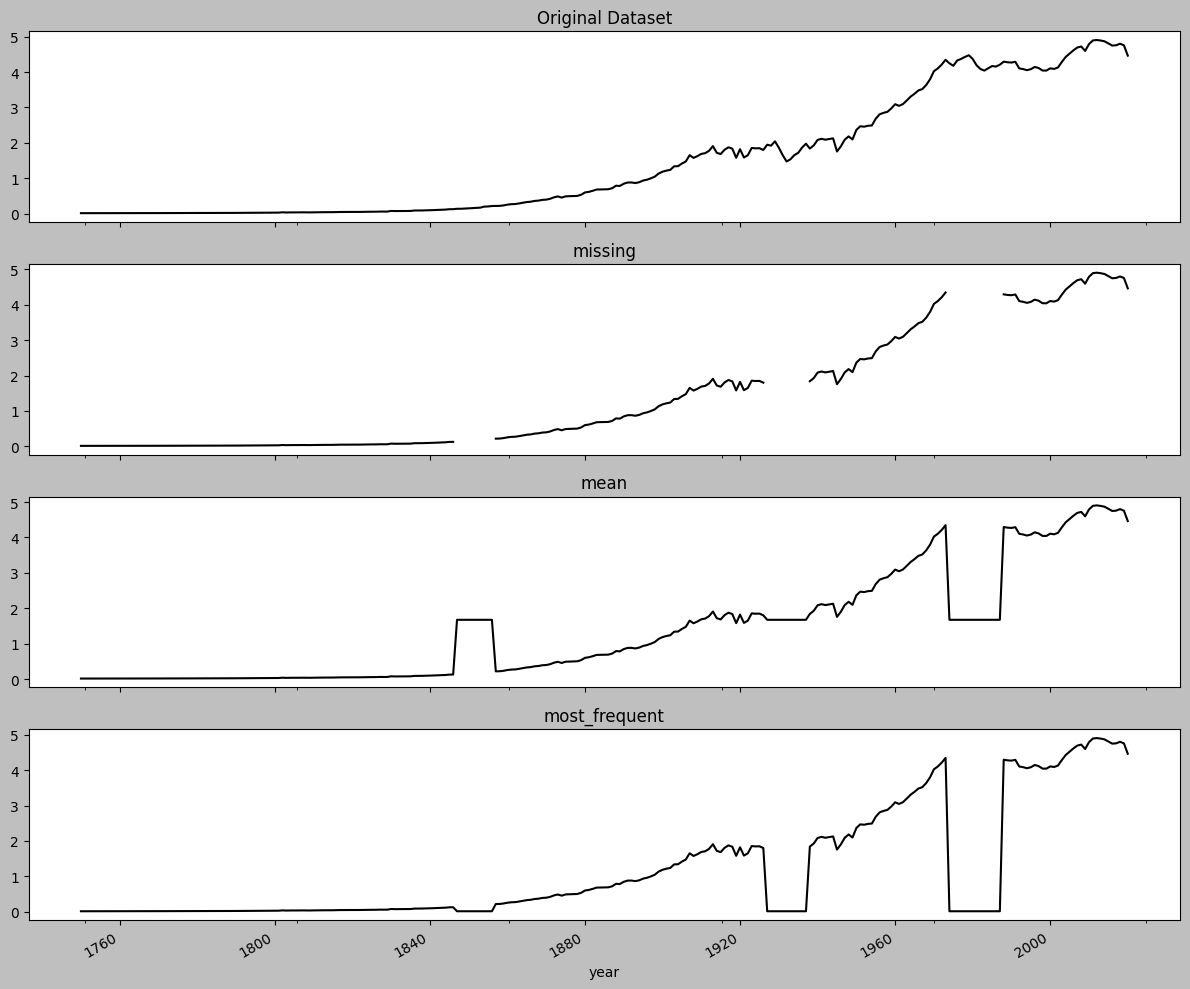

In [31]:
plot_dfs(co2_original,
         co2_missing, 
         'co2')

In [33]:
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)

In [34]:
clicks_original.head()

,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784
2008-04-02,43.079056,1,24738
2008-04-03,43.842609,2,15209
2008-04-04,43.312376,1,14018
2008-04-05,43.941176,1,11974


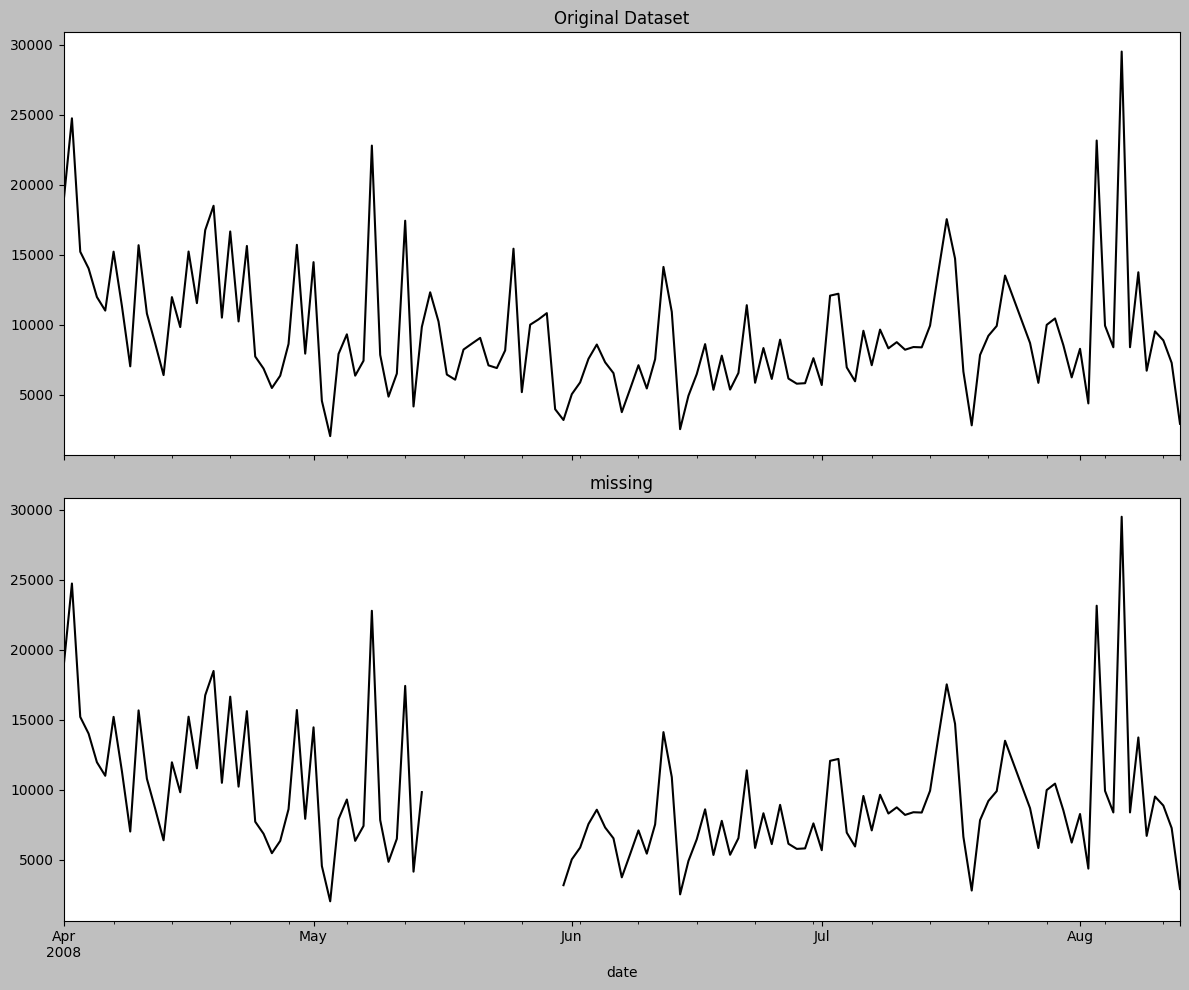

In [35]:
plot_dfs(clicks_original,
         clicks_missing, 
         'clicks')

### Iterative Imputer

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [37]:
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import (ElasticNet, 
                                  LinearRegression, 
                                  BayesianRidge)
from sklearn.neighbors import KNeighborsRegressor

In [53]:
regressors = [
    ('bayesianRidge', BayesianRidge()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=50, random_state=42)),
    ('bagging', BaggingRegressor(n_estimators=50, random_state=42)),
    ('elastic_net', ElasticNet()),
    ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

In [59]:
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)

In [60]:
clicks_vals = clicks_missing.iloc[:, 0:3].to_numpy()

In [62]:
for regression_name, reg_model in regressors:
    estimate = IterativeImputer(random_state=42, 
                                estimator=reg_model)
    estimate.fit(clicks_vals)
    clicks_missing[regression_name] = estimate.transform(clicks_vals)[:, 2]

In [63]:
clicks_missing.head()

,price,location,clicks,bayesianRidge,extra_trees,bagging,elastic_net,linear_regression,knn
date,,,,,,,,,
2008-04-01,43.155647,2,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0,18784.0
2008-04-02,43.079056,1,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0,24738.0
2008-04-03,43.842609,2,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0,15209.0
2008-04-04,43.312376,1,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0,14018.0
2008-04-05,43.941176,1,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0,11974.0


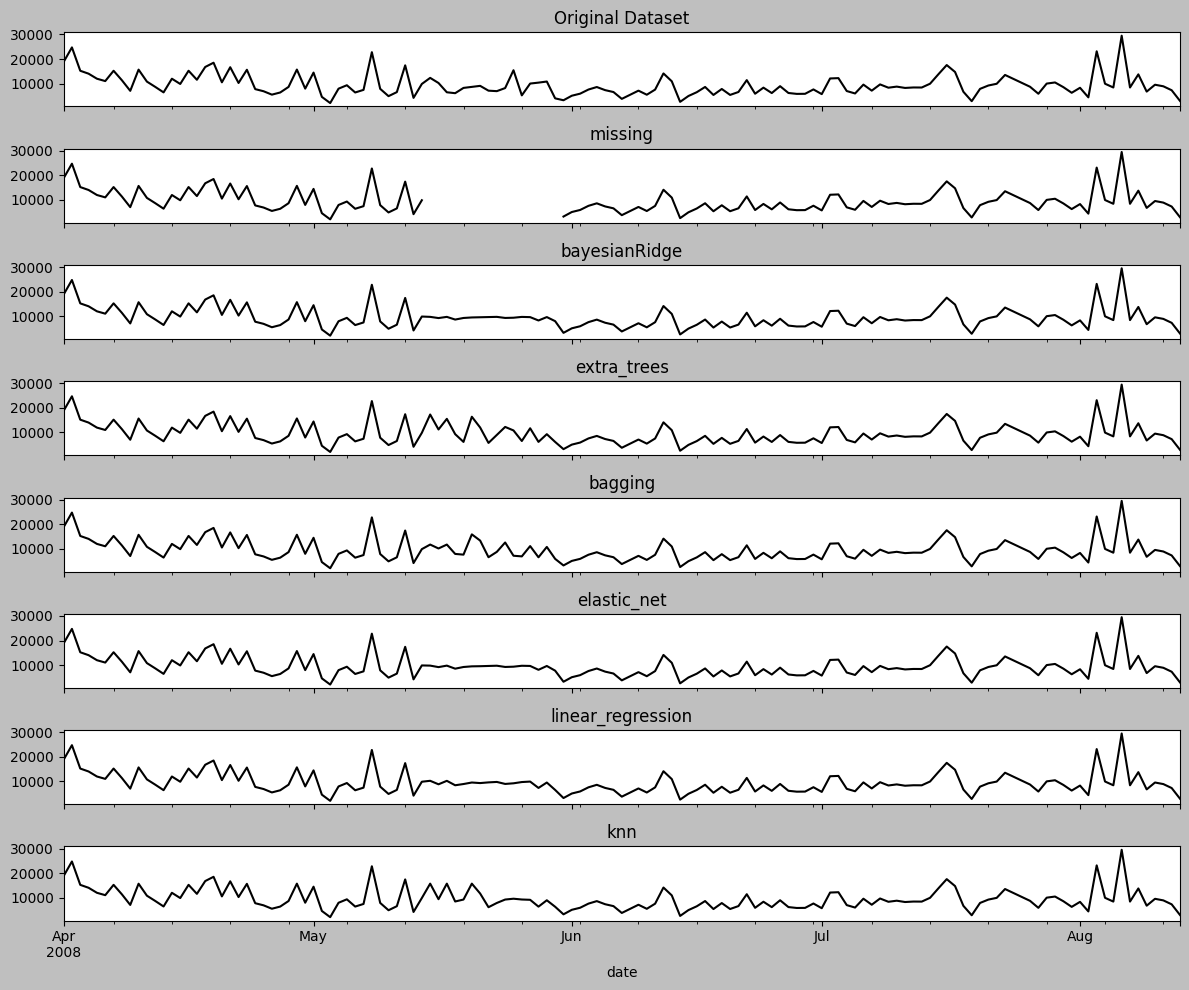

In [64]:
plot_dfs(clicks_original,
         clicks_missing, 
         'clicks')

In [65]:
score = rmse_score(clicks_original,
                   clicks_missing,
                   'clicks')

RMSE for bayesianRidge: 949.439397345585
RMSE for extra_trees: 1404.1501333341182
RMSE for bagging: 1265.5100992417892
RMSE for elastic_net: 945.40752093431
RMSE for linear_regression: 938.9419831427184
RMSE for knn: 1336.8798392251822


### Interpolate

In [66]:
co2_original = read_dataset(folder, 'co2_original.csv', 'year', index=True)
co2_missing = read_dataset(folder, 'co2_missing_only.csv', 'year', index=True)
clicks_original = read_dataset(folder, 'clicks_original.csv', 'date', index=True)
clicks_missing = read_dataset(folder, 'clicks_missing.csv', 'date', index=True)

In [68]:
interpolations = [
    'linear',
    'quadratic', 
    'nearest', 
    'cubic'
]

In [71]:
for inter in interpolations:
    co2_missing[inter] = co2_missing['co2'].interpolate(method=inter)

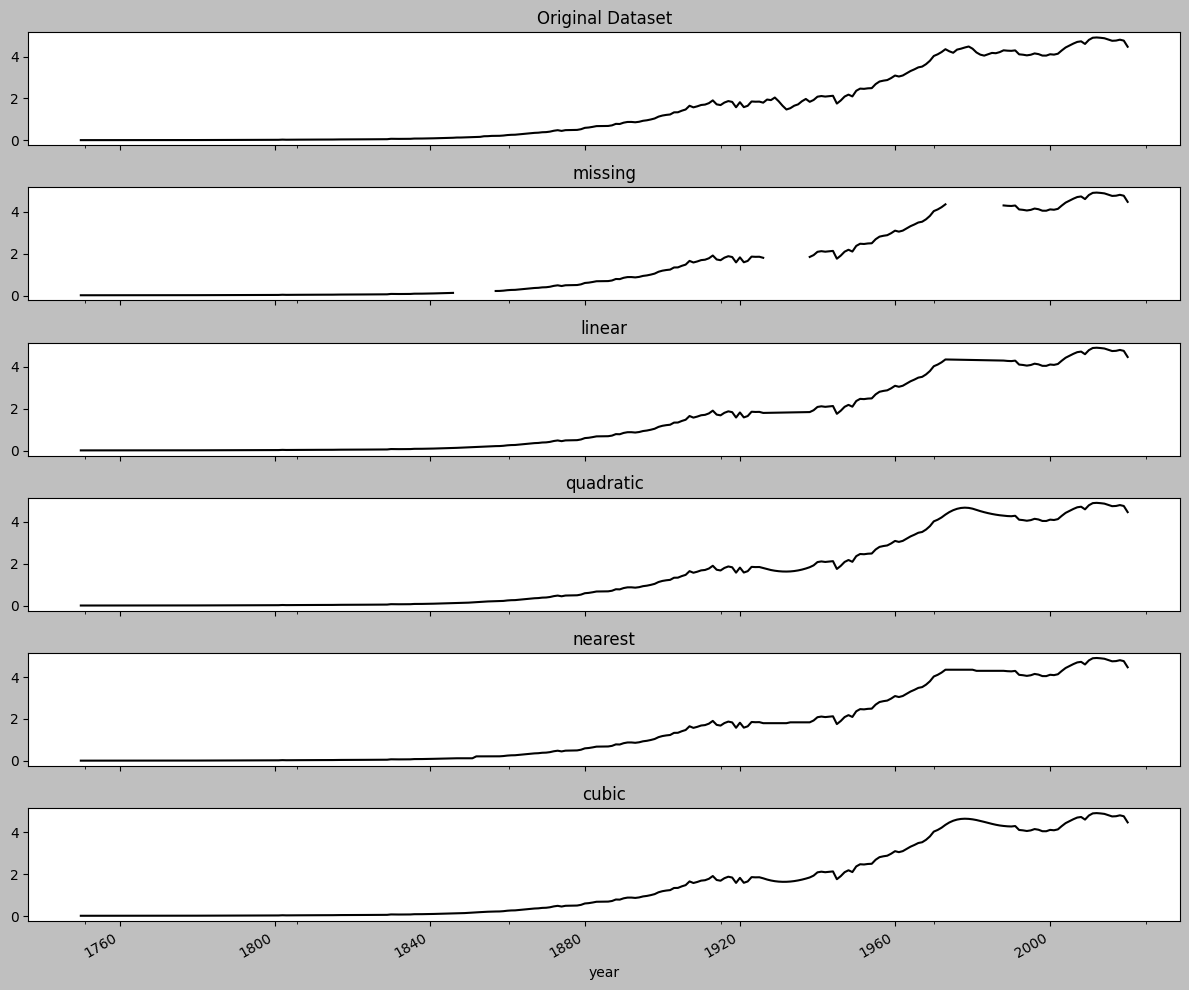

In [72]:
plot_dfs(co2_original,
         co2_missing, 
         'co2')

In [73]:
rmse_score(co2_original,
           co2_missing, 
           'co2')

RMSE for linear: 0.05507291327761665
RMSE for quadratic: 0.08367561505614346
RMSE for nearest: 0.05385422309469095
RMSE for cubic: 0.08373627305833138


[np.float64(0.05507291327761665),
 np.float64(0.08367561505614346),
 np.float64(0.05385422309469095),
 np.float64(0.08373627305833138)]

In [75]:
for inter in interpolations:
    clicks_missing[inter] = clicks_missing['clicks'].interpolate(method=inter)

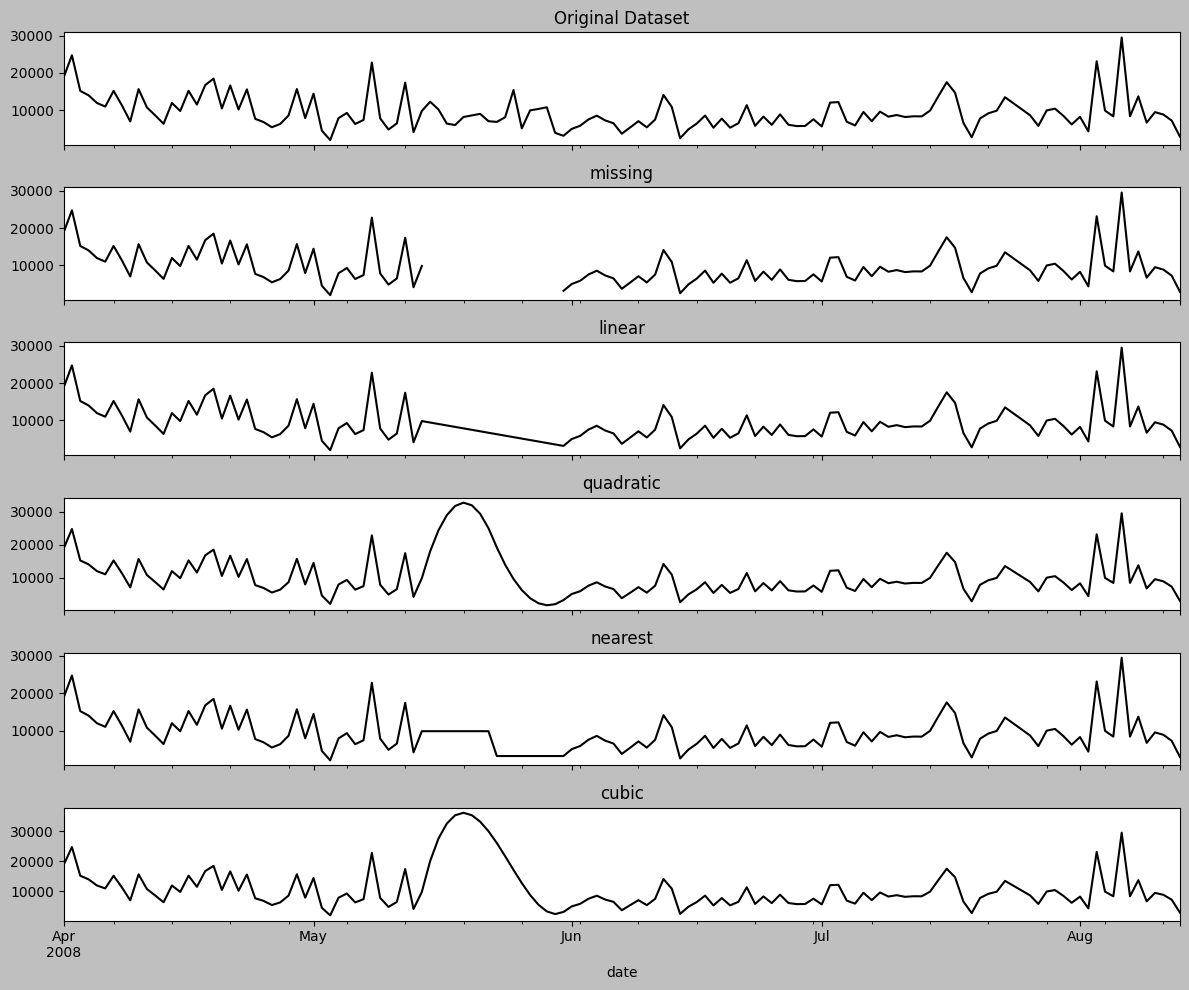

In [76]:
plot_dfs(clicks_original,
         clicks_missing, 
         'clicks')

In [77]:
rmse_score(clicks_original,
           clicks_missing, 
           'clicks')

RMSE for linear: 1329.1448378562811
RMSE for quadratic: 5224.641260626974
RMSE for nearest: 1706.1853705030173
RMSE for cubic: 6199.304875782833


[np.float64(1329.1448378562811),
 np.float64(5224.641260626974),
 np.float64(1706.1853705030173),
 np.float64(6199.304875782833)]